In [11]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [12]:
print(os.listdir("./"))

['.config', 'sample_data']


In [13]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [14]:
filenames = os.listdir("/content/sample_data/train")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'dancing':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
df["category"] = df["category"].replace({0: 'arching', 1: 'dancing'}) 


In [16]:
df.head()

,filename,category
0,arching_122.jpg,arching
1,arching_24.jpg,arching
2,arching_86.jpg,arching
3,dancing_229.jpg,dancing
4,arching_31.jpg,arching


<Axes: >

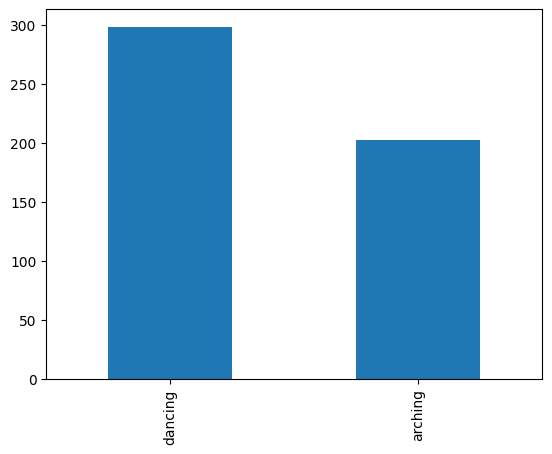

In [17]:
df['category'].value_counts().plot.bar()

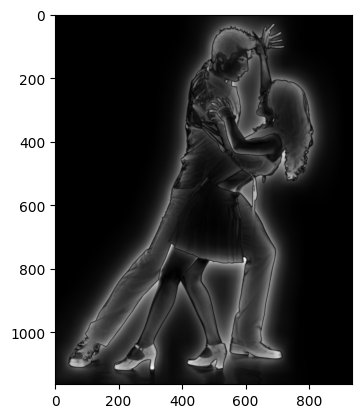

In [18]:
sample = random.choice(filenames)
image = load_img("/content/sample_data/train/"+sample)
plt.imshow(image)

In [19]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the input shape of the ResNet50 model
input_shape = (224, 224, 3)

# Load the ResNet50 model, excluding the fully connected layers at the top
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the weights of the ResNet50 model, so we don't update them during training
for layer in resnet.layers:
    layer.trainable = False

# Add new fully connected layers at the top of the ResNet50 model for our binary classification task
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Build the new model by combining the ResNet50 model and our fully connected layers
model = Model(inputs=resnet.input, outputs=predictions)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


94765736/94765736 [==============================] - 3s 0us/step


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Load the dataframe with x and y labels


# Split the dataframe into training, validation, and testing subsets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Define the training, validation, and testing generators using flow_from_dataframe()
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/sample_data/train',
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/sample_data/train',
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/sample_data/train',
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
print(len(train_generator))
# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

# Evaluate the model on the testing set
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Found 256 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
8
Epoch 1/10
8/8 [==============================] - 79s 9s/step - loss: 0.7993 - accuracy: 0.6016 - val_loss: 0.8574 - val_accuracy: 0.3125
Epoch 2/10
8/8 [==============================] - 62s 8s/step - loss: 0.7030 - accuracy: 0.6328 - val_loss: 0.5729 - val_accuracy: 0.6875
Epoch 3/10
8/8 [==============================] - 60s 7s/step - loss: 0.6947 - accuracy: 0.6172 - val_loss: 0.5396 - val_accuracy: 0.6875
Epoch 4/10
8/8 [==============================] - 61s 8s/step - loss: 0.5751 - accuracy: 0.6797 - val_loss: 0.5548 - val_accuracy: 0.6875
Epoch 5/10
8/8 [==============================] - 61s 8s/step - loss: 0.5692 - accuracy: 0.7109 - val_loss: 0.5392 - val_accuracy: 0.6875
Epoch 6/10
8/8 [==============================] - 58s 7s/step - loss: 0.5333 - accuracy: 0.7188 - val_loss: 0.5514 - val_accuracy

4/4 [==============================] - 22s 5s/step


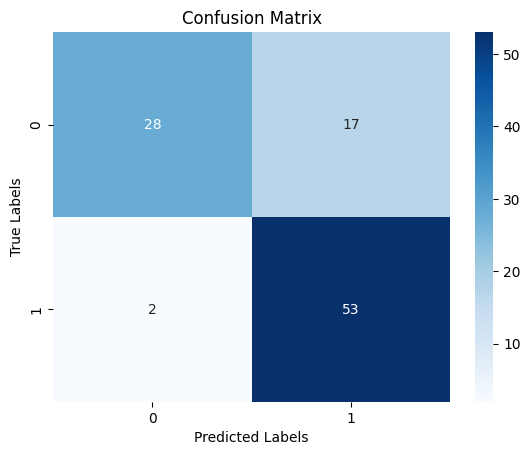

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get true labels for test data
y_true = test_generator.classes

y_pred = model.predict(test_generator)
y_pred = y_pred.round()

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

# set plot labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# show plot
plt.show()


In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# print precision, and recall
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Precision: 0.76
Recall: 0.96


In [23]:
from sklearn.metrics import f1_score
# calculate F1 score
f1 = f1_score(y_true, y_pred)

# print F1 score
print("F1 Score: {:.2f}".format(f1))

F1 Score: 0.85
